In [21]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

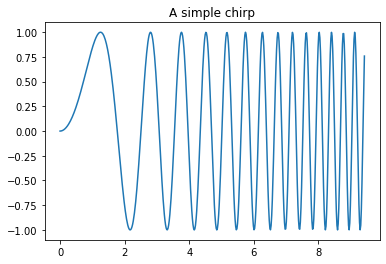

In [22]:
#Checking that plotlib works
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp')
plt.show()

In [23]:
import tlquantum as tlq
import tensorly as tl
from tqdm import tqdm
from torch import complex64, nn, optim, real
import json

In [24]:
#Global parameters
dt=0.01
device =  'cpu'
approx = 2
ncontraq, ncontral = 2, 2

In [25]:
def prepare_circuit(N, L, axes = ['x', 'z', 'x']):
    #Rotations 
    unitaries = []
    for i in range(L):
        for a in range(len(axes)):
            unitaries.append(tlq.UnaryGatesUnitary(N, ncontraq, axis=axes[a], device=device))
        #Star 
        unitaries.append(tlq.Perceptron_U(N, 2, approx, dt=dt, device=device))
        
    return tlq.TTCircuit(unitaries, ncontraq, ncontral)

def kernel(circuit, input, op, criterion): 
    o=circuit.forward_expectation_value(input, op)
    l=criterion(real(o), tl.tensor([0]))
    l.backward()
    K = 0
    for p in circuit.parameters():
        for e in p.grad: 
            K += ((e/l)*(e/l)).item()
    return K

### Four qubits, XZX pulses

In the following cells we employ four qubits, with all the axes turned on, and a depth of $L$ and sample the kernel. 

In [26]:
N=4
L=16
Nsamples=1000
Ntrials = 1
psi0 = tlq.spins_to_tt_state([0 for i in range(N)], device=device,dtype=complex64) # generate generic zero state |00000>
psi0 = tlq.qubits_contract(psi0, ncontraq)
opz = [tlq.IDENTITY().forward()]*(N-1)+[tlq.pauli_z()]

In [27]:
crt=nn.MSELoss()

Ks = np.zeros((Ntrials, Nsamples))

for t in tqdm(range(Ntrials)):
    for i in range(Nsamples):
        c = prepare_circuit(N,L, axes=['x', 'z'])
        Ks[t,i]= kernel(c, psi0, opz, crt)
        
    
dic = {'N':N, 'L': L, 'Nsamples': Nsamples, 'Ntrials': Ntrials, 'Ks': Ks.tolist()}

with open('Kernels_N4_L16_XZ_uniform.json', 'w') as ofile: 
    json.dump(dic, ofile)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:58<00:00, 358.34s/it]


### Four qubits, Z pulses

In the following cells we employ four qubits, with only pulses along z turned on, and a depth of $L$ and sample the kernel. 

In [28]:
crt=nn.MSELoss()

Ks = np.zeros((Ntrials, Nsamples))

for t in tqdm(range(Ntrials)):
    for i in range(Nsamples):
        c = prepare_circuit(N,L, axes=['z'])
        Ks[t,i]= kernel(c, psi0, opz, crt)
        
    
dic = {'N':N, 'L': L, 'Nsamples': Nsamples, 'Ntrials': Ntrials, 'Ks': Ks.tolist()}

with open('Kernels_N4_L16_Z_uniform.json', 'w') as ofile: 
    json.dump(dic, ofile)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:04<00:00, 244.88s/it]


In [38]:
#Opening data to plot
with open('Kernels_N4_L16_XZ_uniform.json', 'r') as infile: 
    data=json.load(infile)

Ks_ZX =np.array(data['Ks'])[0,:]

with open('Kernels_N4_L16_Z_uniform.json', 'r') as infile: 
    data=json.load(infile)

Ks_Z = np.array(data['Ks'])[0,:]

In [50]:
Ks_ZX_clean = []

for k in Ks_ZX: 
    if k<2e4: Ks_ZX_clean.append(k)
        
Ks_Z_clean = []

for k in Ks_Z: 
    if k<2e4: Ks_Z_clean.append(k)

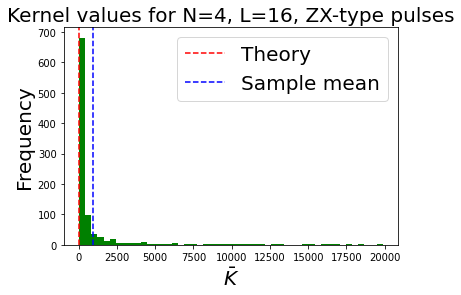

In [49]:
bins = np.linspace(min(Ks_ZX_clean), max(Ks_ZX_clean), 50)
H=2**N
theory = L*(H)**2*2/(H+1)*(4*N+2)/(H**2+1)
mean = sum(Ks_ZX_clean)/len(Ks_ZX_clean)

plt.figure()
plt.hist(Ks_ZX_clean,bins=bins, color='g', alpha=1)
plt.axvline(x=theory, color='red', linestyle='--', label='Theory')
plt.axvline(x=mean, color='blue', linestyle='--', label='Sample mean')
plt.xlabel(r'$\bar{K}$', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(fontsize=20)
plt.title('Kernel values for N=4, L=16, ZX-type pulses', fontsize=20)
plt.show()

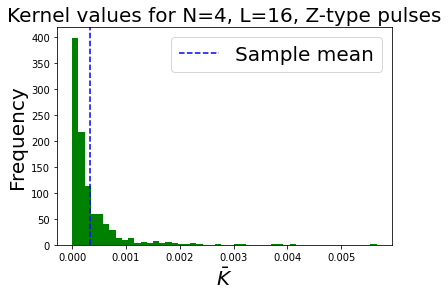

In [51]:
bins = np.linspace(min(Ks_Z_clean), max(Ks_Z_clean),50)
H=2**N
theory = L*(H)**2*2/(H+1)*(4*N+2)/(H**2+1)
mean = sum(Ks_Z_clean)/len(Ks_Z_clean)

plt.figure()
plt.hist(Ks_Z_clean, bins=bins,color='g', alpha=1)
#plt.axvline(x=theory, color='red', linestyle='--', label='Theory')
plt.axvline(x=mean, color='blue', linestyle='--', label='Sample mean')
plt.xlabel(r'$\bar{K}$', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Kernel values for N=4, L=16, Z-type pulses', fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Training curve and K value as a function of time

In [60]:
#Global parameters
dt=0.01
device =  'cpu'
approx = 2
ncontraq, ncontral = 2, 2

def prepare_circuit(N, L, axes = ['x', 'z', 'x']):
    #Rotations 
    unitaries = []
    for i in range(L):
        for a in range(len(axes)):
            unitaries.append(tlq.UnaryGatesUnitary(N, ncontraq, axis=axes[a], device=device))
        #Star 
        unitaries.append(tlq.Perceptron_U(N, 2, approx, dt=dt, device=device))
        
    return tlq.TTCircuit(unitaries, ncontraq, ncontral)

def train(circuit, input, op, Epochs, crt, opt): 
    crt=nn.MSELoss()
    opt.zero_grad()
    
    loss = []
    Ks = []
    
    for e in tqdm(range(Epochs)): 
        o=circuit.forward_expectation_value(input, op)
        l=crt(real(o), tl.tensor([0]))
        l.backward()
        K = 0
        for p in circuit.parameters():
            for e in p.grad: 
                K += ((e/l)*(e/l)).item()
        Ks.append(K)
        loss.append(l.item())
        opt.step()
        opt.zero_grad()

    return loss, Ks

In [64]:
N, L, Nepochs = 4, 16, 10000
#circuit
c = prepare_circuit(N,L, axes=['x','z'])

#for torch use
opt = optim.Adam([{'params': c.parameters()}],lr=0.001, amsgrad=True)
crt = nn.MSELoss()

#psi0
psi0 = tlq.spins_to_tt_state([0 for i in range(N)], device=device,dtype=complex64) # generate generic zero state |00000>
psi0 = tlq.qubits_contract(psi0, ncontraq)

#operator to measure
opz = [tlq.IDENTITY().forward()]*(N-1)+[tlq.pauli_z()]

loss, Ks = train(c, psi0, opz, Epochs, crt, opt)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.38it/s]
